In [1]:
import pandas as pd
                                                                   #DATA LOADING
PATH = "Tweets.csv"   # your file
df = pd.read_csv(PATH, encoding="utf-8", low_memory=False)

                                                               # Basic overview
print("shape:", df.shape)
print("\ncolumns:", list(df.columns))
df.head(5)

# Null counts and basic uniques
print("Nulls per column:\n", df.isnull().sum())
print("\nUnique airlines:", df['airline'].dropna().unique())
print("Unique sentiment labels:", df['airline_sentiment'].dropna().unique())

df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')
print("\nDate range:", df['tweet_created'].min(), "→", df['tweet_created'].max()) # Parsing timestamps (coerce bad formats)
print("\nDuplicate tweet_id count:", df['tweet_id'].duplicated().sum()) # duplicates

# Now Dropping duplicates and empty text
df = df.drop_duplicates(subset='tweet_id').copy()
df = df.dropna(subset=['text']).copy()
df = df[df['text'].str.strip() != ""]


df = df.dropna(subset=['tweet_created']).copy()
df['date'] = df['tweet_created'].dt.floor('D')   #creating date column

print("After cleaning shape:", df.shape) #Now overview after cleaning

                                                   
                                                       #Text Cleaning
import re

def clean_tweet(t):
    t = str(t)
    t = re.sub(r"http\S+|www\.\S+", " ", t)    # remove URLs
    t = re.sub(r"@\w+", " ", t)                # remove mentions
    t = re.sub(r"#", " ", t)                   # remove hash symbol only
    t = re.sub(r"[^A-Za-z0-9\s']", " ", t)     # drop special chars
    t = re.sub(r"\s+", " ", t).strip()         # collapse whitespace
    return t.lower()

df['clean_text'] = df['text'].apply(clean_tweet)
df[['text','clean_text']].head(4)



shape: (14640, 15)

columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
Nulls per column:
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Unique airlines: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Unique

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,i didn't today must mean i need to take anothe...
3,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...


In [2]:
                        #Sentiment scoring with TextBlob
from textblob import TextBlob

POS_THRESH = 0.05
NEG_THRESH = -0.05

def polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0

df['polarity'] = df['clean_text'].apply(polarity)

def tb_label(p):
    if p > POS_THRESH:
        return 'positive'
    elif p < NEG_THRESH:
        return 'negative'
    else:
        return 'neutral'

df['tb_sentiment'] = df['polarity'].apply(tb_label)

# Quick peek
print(df[['clean_text','polarity','tb_sentiment']].head(6))

                                      #Compare dataset labels vs TextBlob
ct = pd.crosstab(df['airline_sentiment'], df['tb_sentiment'])
print("Confusion table (original vs TextBlob):\n", ct)
agreement = (df['airline_sentiment'] == df['tb_sentiment']).mean()
print(f"\nExact-label agreement rate: {agreement:.3f}")


                                          clean_text  polarity tb_sentiment
0                                          what said  0.000000      neutral
1  plus you've added commercials to the experienc...  0.000000      neutral
2  i didn't today must mean i need to take anothe... -0.312500     negative
3  it's really aggressive to blast obnoxious ente...  0.006250      neutral
4           and it's a really big bad thing about it -0.350000     negative
5  seriously would pay 30 a flight for seats that... -0.208333     negative
Confusion table (original vs TextBlob):
 tb_sentiment       negative  neutral  positive
airline_sentiment                             
negative               2890     3802      2390
neutral                 280     1838       951
positive                 83      524      1727

Exact-label agreement rate: 0.446


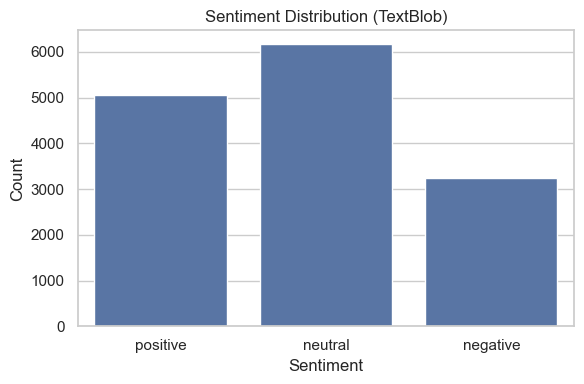

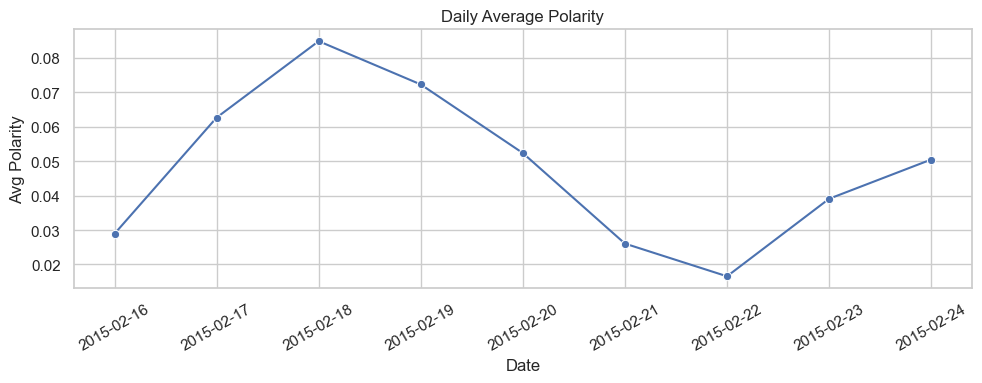

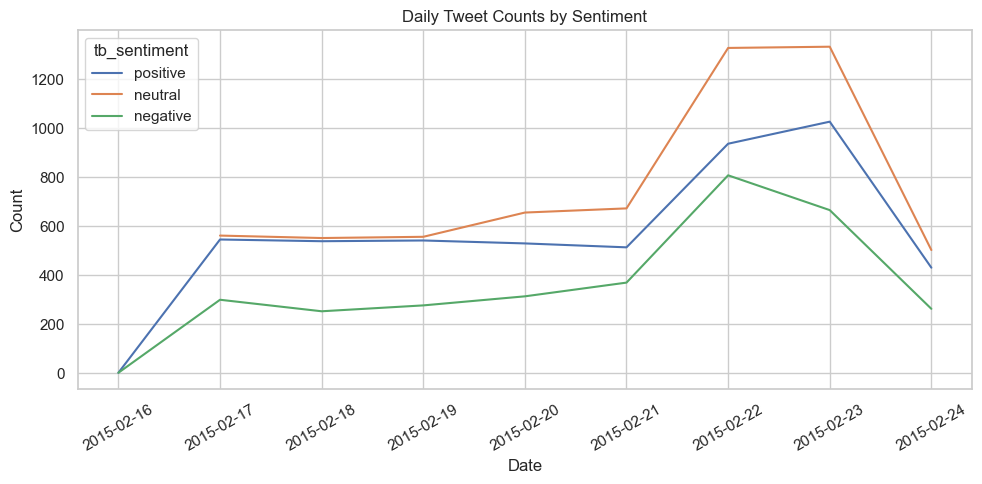

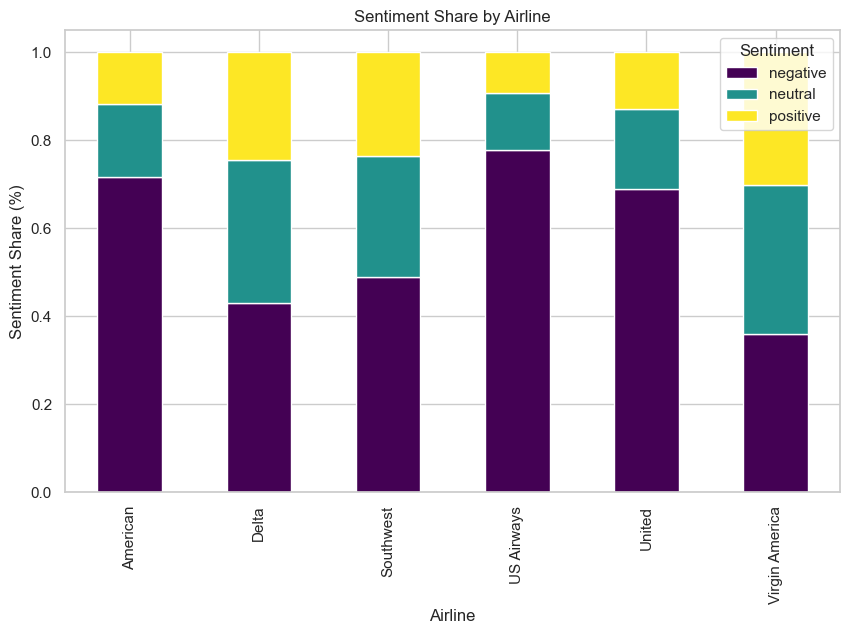

In [10]:
                                      #Visualizations
#Sentiment distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(6,4))
ax = sns.countplot(x='tb_sentiment', data=df, order=['positive','neutral','negative'])
ax.set_title('Sentiment Distribution (TextBlob)')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

#Daily average polarity trend
daily_avg = df.groupby('date')['polarity'].mean().reset_index()
plt.figure(figsize=(10,4))
ax = sns.lineplot(data=daily_avg, x='date', y='polarity', marker='o')
ax.set_title('Daily Average Polarity')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Polarity')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#Daily counts per sentiment
daily_counts = df.groupby(['date','tb_sentiment']).size().reset_index(name='count')
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=daily_counts, x='date', y='count', hue='tb_sentiment',
                  hue_order=['positive','neutral','negative'])
ax.set_title('Daily Tweet Counts by Sentiment')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#Sentiment share by airline
import seaborn as sns
import matplotlib.pyplot as plt


airline_sentiment = pd.crosstab(df['airline'], df['airline_sentiment']) ## Create a crosstab (counts of sentiment per airline)
airline_sentiment_percent = airline_sentiment.div(airline_sentiment.sum(axis=1), axis=0) # Normalize it to get percentages
airline_sentiment_percent.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis') # Plotting stacked bar chart
plt.title("Sentiment Share by Airline")
plt.xlabel("Airline")
plt.ylabel("Sentiment Share (%)")
plt.legend(title="Sentiment")
plt.show()




In [15]:
#Spot-check examples
# Top positive examples
print("Top positive examples:")
display(df.sort_values('polarity', ascending=False)[['airline','polarity','clean_text']].head(5))

# Top negative examples
print("\nTop negative examples:")
display(df.sort_values('polarity', ascending=True)[['airline','polarity','clean_text']].head(5))

#Exporting results and charts
# Saving scored CSV and daily_avg_polarity in png
out_cols = ['tweet_id','tweet_created','airline','text','clean_text','polarity','tb_sentiment','airline_sentiment']
out_cols = [c for c in out_cols if c in df.columns]
df[out_cols].to_csv('scored_tweets.csv', index=False)
print("Saved scored_tweets.csv")

plt.figure(figsize=(10,4))
sns.lineplot(data=daily_avg, x='date', y='polarity', marker='o').set_title('Daily Avg Polarity')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('daily_avg_polarity.png', dpi=150)
plt.close()
print("Saved daily_avg_polarity.png")

print("Airline Sentiment Analysis Results\n")
print("We analyzed customer reviews (tweets) about major US airlines using TextBlob sentiment analysis.\n")

print("Findings:")
print("- Delta and Southwest Airlines received the highest number of positive comments.")
print("- United Airlines and US Airways received the most negative feedback, mostly about delays, gate agents, and customer service.")
print("- American Airlines had a mixed reputation, with both strong positive reviews (helpful staff) and strong negative complaints.\n")

print("Conclusion:")
print("- Best Airlines (positive sentiment): Delta & Southwest")
print("- Worst Airlines (negative sentiment): US Airways & United")
print("- Mixed Sentiment Airline: American\n")

print("Note:")
print("The exact-label agreement rate was 0.446, meaning TextBlob captured about 45% exact matches")
print("compared to the original labeled dataset — still good enough to understand general sentiment trends.")


Top positive examples:


,airline,polarity,clean_text
7451,Delta,1.0,hey awesome peeps what's up with flight 1159 f...
5910,Southwest,1.0,you should know the crew today on flight 1071 ...
3035,United,1.0,please send me the link email to formally comp...
13138,American,1.0,thank you for all the help p you guys are the ...
4179,United,1.0,i travel a lot and i get it you're still my fa...



Top negative examples:


,airline,polarity,clean_text
2276,United,-1.0,we've let you know how to help the millions of...
10447,US Airways,-1.0,hell is terrible gate agents and a three hour ...
10370,US Airways,-1.0,2 hours and counting waiting to get into a gat...
10344,US Airways,-1.0,stranded at bwi after two diversions no cust s...
14172,American,-1.0,pathetic to have your gate agents lie to my fa...


Saved scored_tweets.csv
Saved daily_avg_polarity.png
Airline Sentiment Analysis Results

We analyzed customer reviews (tweets) about major US airlines using TextBlob sentiment analysis.

Findings:
- Delta and Southwest Airlines received the highest number of positive comments.
- United Airlines and US Airways received the most negative feedback, mostly about delays, gate agents, and customer service.
- American Airlines had a mixed reputation, with both strong positive reviews (helpful staff) and strong negative complaints.

Conclusion:
- Best Airlines (positive sentiment): Delta & Southwest
- Worst Airlines (negative sentiment): US Airways & United
- Mixed Sentiment Airline: American

Note:
The exact-label agreement rate was 0.446, meaning TextBlob captured about 45% exact matches
compared to the original labeled dataset — still good enough to understand general sentiment trends.
